In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

file_path = '/kaggle/input/sms-spam-collection-dataset/spam.csv'

df = pd.read_csv(file_path, encoding='latin-1')

df.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], inplace=True, errors='ignore')

df.rename(columns={'v1': 'label', 'v2': 'message'}, inplace=True)

print("Veri setinin temizlenmiş hali (ilk 5 satır):")
print(df.head())
print("\n" + "="*50 + "\n") # Ayraç

print("Veri seti hakkında genel bilgiler:")
df.info()

Veri setinin temizlenmiş hali (ilk 5 satır):
  label                                            message
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...


Veri seti hakkında genel bilgiler:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5572 non-null   object
 1   message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


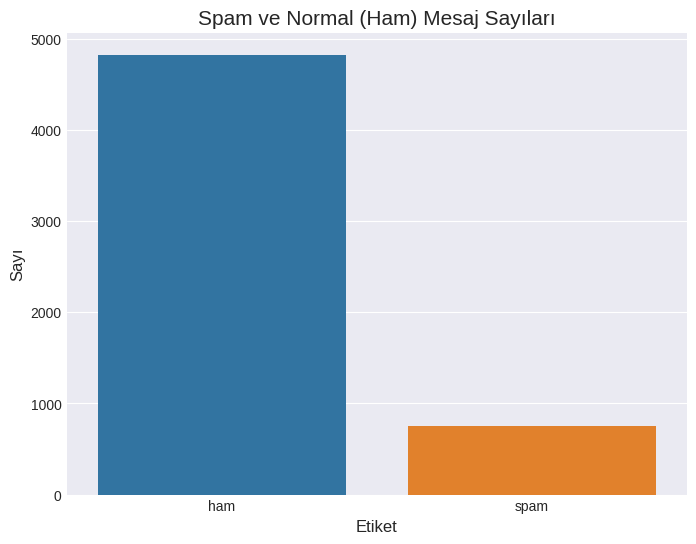

Mesaj Sayıları:
label
ham     4825
spam     747
Name: count, dtype: int64




/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

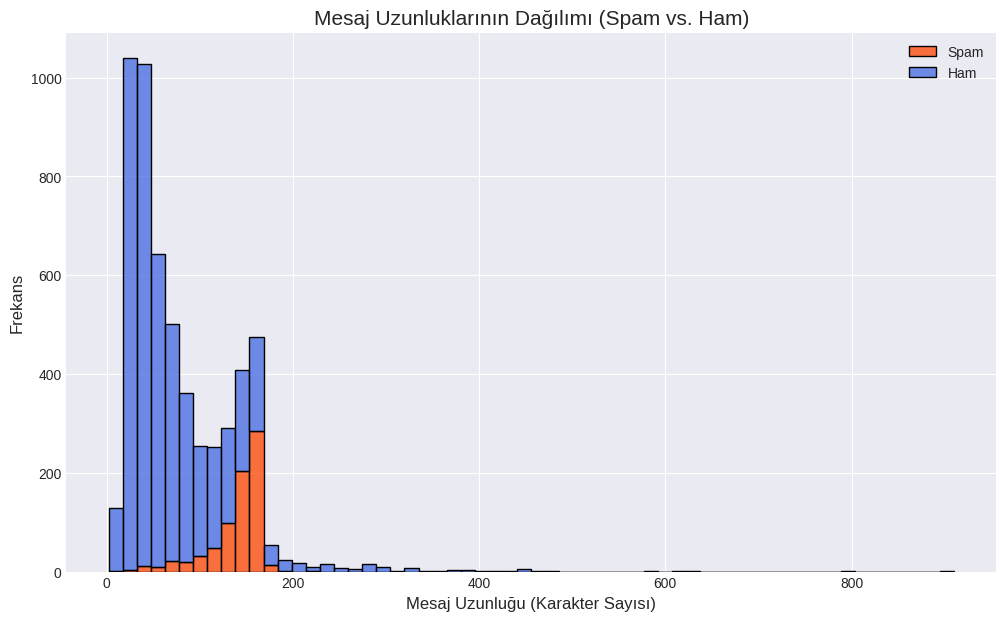

Mesaj Uzunluğu İstatistikleri:
        count        mean        std   min    25%    50%    75%    max
label                                                                 
ham    4825.0   71.023627  58.016023   2.0   33.0   52.0   92.0  910.0
spam    747.0  138.866131  29.183082  13.0  132.5  149.0  157.0  224.0


In [2]:
# 1. SPAM VE NORMAL MESAJ SAYILARINI GÖRSELLEŞTİRME

# Grafik stilini belirleyelim
plt.style.use('seaborn-v0_8-darkgrid')

plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=df)
plt.title('Spam ve Normal (Ham) Mesaj Sayıları', fontsize=15)
plt.xlabel('Etiket', fontsize=12)
plt.ylabel('Sayı', fontsize=12)
plt.show()

# Sayıları net olarak görelim
print("Mesaj Sayıları:")
print(df['label'].value_counts())
print("\n" + "="*50 + "\n")


# 2. MESAJ UZUNLUKLARINI ANALİZ ETME

df['message_length'] = df['message'].apply(len)

plt.figure(figsize=(12, 7))
sns.histplot(data=df, x='message_length', hue='label', bins=60, multiple='stack', palette={'ham': 'royalblue', 'spam': 'orangered'})
plt.title('Mesaj Uzunluklarının Dağılımı (Spam vs. Ham)', fontsize=15)
plt.xlabel('Mesaj Uzunluğu (Karakter Sayısı)', fontsize=12)
plt.ylabel('Frekans', fontsize=12)
plt.legend(['Spam', 'Ham'])
plt.show()

print("Mesaj Uzunluğu İstatistikleri:")
print(df.groupby('label')['message_length'].describe())

In [3]:
import string
import nltk 
from nltk.corpus import stopwords

try:
    stopwords.words('english')
except LookupError:
    nltk.download('stopwords')

# Metin temizleme fonksiyonumuzu tanımlayalım
def text_process(message):
    """
    1. Noktalama işaretlerini kaldırır.
    2. Anlamsız durdurma kelimelerini (stopwords) kaldırır.
    3. Temizlenmiş kelimelerin listesini döndürür.
    """
    # 1. Noktalama işaretlerini kontrol et ve kaldır
    nopunc = [char for char in message if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    
    # 2. Kelimelere ayır, küçük harfe çevir ve anlamsız kelimeleri kaldır
    clean_words = [word.lower() for word in nopunc.split() if word.lower() not in stopwords.words('english')]
    
    return ' '.join(clean_words)


# Fonksiyonumuzu tüm 'message' sütununa uygulayalım ve yeni bir sütun oluşturalım
df['clean_message'] = df['message'].apply(text_process)

# Yeni halini görelim
print("Metinler temizlendi. Orijinal ve temizlenmiş halleri:")
print(df[['message', 'clean_message']].head())

Metinler temizlendi. Orijinal ve temizlenmiş halleri:
                                             message  \
0  Go until jurong point, crazy.. Available only ...   
1                      Ok lar... Joking wif u oni...   
2  Free entry in 2 a wkly comp to win FA Cup fina...   
3  U dun say so early hor... U c already then say...   
4  Nah I don't think he goes to usf, he lives aro...   

                                       clean_message  
0  go jurong point crazy available bugis n great ...  
1                            ok lar joking wif u oni  
2  free entry 2 wkly comp win fa cup final tkts 2...  
3                u dun say early hor u c already say  
4        nah dont think goes usf lives around though  


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# 1. VERİYİ EĞİTİM VE TEST SETLERİNE AYIRMA
X = df['clean_message']  
y = df['label']          

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# 2. TF-IDF VEKTÖRLEŞTİRİCİYİ OLUŞTURMA VE UYGULAMA
tfidf_vectorizer = TfidfVectorizer()

# fit_transform: Önce TÜM EĞİTİM verisindeki kelimeleri öğrenir (fit),
# sonra bu kelimelere göre EĞİTİM verisini sayısal bir matrise dönüştürür (transform).
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# transform: Test verisi üzerinde YENİDEN kelime öğrenmez. 
# Sadece eğitim verisinden öğrendiği kelimelere göre test verisini dönüştürür.
# Bu, modelin test sırasında "kopya çekmesini" engeller.
X_test_tfidf = tfidf_vectorizer.transform(X_test)


# 3. SONUCU KONTROL ETME
print("Eğitim verisinin boyutu (mesaj sayısı, benzersiz kelime sayısı):")
print(X_train_tfidf.shape)

print("\nTest verisinin boyutu (mesaj sayısı, benzersiz kelime sayısı):")
print(X_test_tfidf.shape)

Eğitim verisinin boyutu (mesaj sayısı, benzersiz kelime sayısı):
(4457, 8270)

Test verisinin boyutu (mesaj sayısı, benzersiz kelime sayısı):
(1115, 8270)


In [5]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 1. MODELİ OLUŞTURMA
# Multinomial Naive Bayes modelini başlatalım
model = MultinomialNB()

# 2. MODELİ EĞİTME
# Modelimize sayısallaştırılmış eğitim mesajlarını (X_train_tfidf) ve 
# bu mesajların gerçek etiketlerini (y_train) vererek "öğrenmesini" sağlıyoruz.
# .fit() komutu, modelin kelimeler ve etiketler arasındaki ilişkiyi öğrendiği yerdir.
print("Model eğitimi başlıyor...")
model.fit(X_train_tfidf, y_train)
print("Model eğitimi tamamlandı!")

# 3. TEST VERİSİ ÜZERİNDE TAHMİN YAPMA
print("\nTest verisi üzerinde tahminler yapılıyor...")
predictions = model.predict(X_test_tfidf)
print("Tahminler tamamlandı!")

Model eğitimi başlıyor...
Model eğitimi tamamlandı!

Test verisi üzerinde tahminler yapılıyor...
Tahminler tamamlandı!


Modelin Doğruluk Oranı: 96.77%


Sınıflandırma Raporu:
              precision    recall  f1-score   support

         ham       0.96      1.00      0.98       965
        spam       1.00      0.76      0.86       150

    accuracy                           0.97      1115
   macro avg       0.98      0.88      0.92      1115
weighted avg       0.97      0.97      0.97      1115



Karışıklık Matrisi:


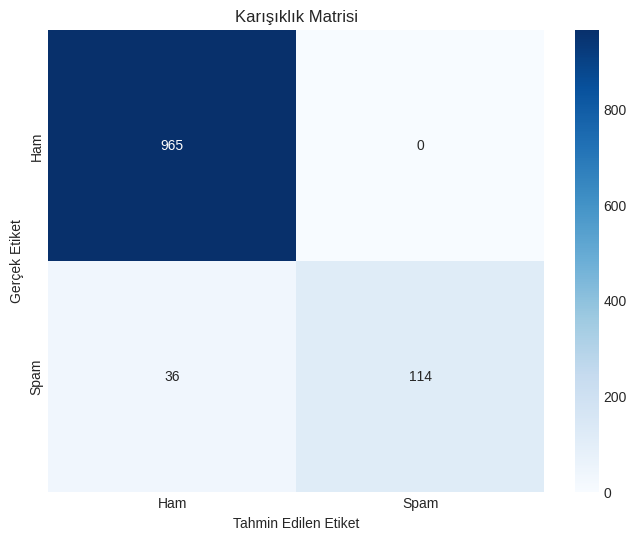

In [6]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1. DOĞRULUK SKORUNU HESAPLAMA
accuracy = accuracy_score(y_test, predictions)
print(f"Modelin Doğruluk Oranı: {accuracy * 100:.2f}%")
print("\n" + "="*50 + "\n")

# 2. SINIFLANDIRMA RAPORUNU GÖRÜNTÜLEME
# Bu rapor bize precision, recall ve f1-score gibi çok önemli metrikleri verir.
print("Sınıflandırma Raporu:")
print(classification_report(y_test, predictions))
print("\n" + "="*50 + "\n")

# 3. KARIŞIKLIK MATRİSİNİ GÖRSELLEŞTİRME
print("Karışıklık Matrisi:")
cm = confusion_matrix(y_test, predictions)

# Matrisi daha okunabilir hale getirmek için bir heatmap (ısı haritası) çizelim
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.xlabel('Tahmin Edilen Etiket')
plt.ylabel('Gerçek Etiket')
plt.title('Karışıklık Matrisi')
plt.show()

In [7]:
# Test etmek için kendi cümlelerimizi bir liste yapalım
my_messages = [
    "Congratulations! You've won a $1000 Walmart gift card. Go to http://example.com to claim now.", # Açıkça spam
    "Hi mom, I'll be home late for dinner tonight. Can you save me some food?", # Açıkça normal (ham)
    "URGENT! Your account has been compromised. Click here to secure your account immediately.", # Açıkça spam
    "Hey, are we still on for the meeting tomorrow at 2pm?", # Açıkça normal (ham)
]

# 1. Cümlelerimizi sayısallaştıralım.
# Bu adımda metinleri, modelin anlayacağı sayısal formata çeviriyoruz.
my_messages_tfidf = tfidf_vectorizer.transform(my_messages)

# 2. Tahmin yapalım
my_predictions = model.predict(my_messages_tfidf)

# 3. Sonuçları yazdıralım
for message, prediction in zip(my_messages, my_predictions):
    print(f"Mesaj: '{message}' -> Tahmin: {prediction.upper()}")

Mesaj: 'Congratulations! You've won a $1000 Walmart gift card. Go to http://example.com to claim now.' -> Tahmin: SPAM
Mesaj: 'Hi mom, I'll be home late for dinner tonight. Can you save me some food?' -> Tahmin: HAM
Mesaj: 'URGENT! Your account has been compromised. Click here to secure your account immediately.' -> Tahmin: HAM
Mesaj: 'Hey, are we still on for the meeting tomorrow at 2pm?' -> Tahmin: HAM


In [8]:
import pickle

with open('spam_model.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)

# Vektörleştiriciyi kaydetmek için bir dosya açalım
with open('vectorizer.pkl', 'wb') as vectorizer_file:
    pickle.dump(tfidf_vectorizer, vectorizer_file)

print("\nModel ve Vektörleştirici başarıyla kaydedildi!")
print("Dosyalar: spam_model.pkl, vectorizer.pkl")


Model ve Vektörleştirici başarıyla kaydedildi!
Dosyalar: spam_model.pkl, vectorizer.pkl
